### Sistem Rekomendasi Buku
- Nama: Muhammad Habibulloh
- ID Dicoding: MC258D5Y1827

### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from IPython.display import display, HTML

### Load Dataset

In [ ]:
df = pd.read_csv('goodreads_data.csv')
print(df.head())

print("\nData Shape:", df.shape)

   Unnamed: 0                                               Book  \
0           0                              To Kill a Mockingbird   
1           1  Harry Potter and the Philosopher’s Stone (Harr...   
2           2                                Pride and Prejudice   
3           3                          The Diary of a Young Girl   
4           4                                        Animal Farm   

          Author                                        Description  \
0     Harper Lee  The unforgettable novel of a childhood in a sl...   
1   J.K. Rowling  Harry Potter thinks he is an ordinary boy - un...   
2    Jane Austen  Since its immediate success in 1813, Pride and...   
3     Anne Frank  Discovered in the attic in which she spent the...   
4  George Orwell  Librarian's note: There is an Alternate Cover ...   

                                              Genres  Avg_Rating Num_Ratings  \
0  ['Classics', 'Fiction', 'Historical Fiction', ...        4.27   5,691,311   
1  [

### Exploratory Data Analysis

##### Cek missing values

In [ ]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Unnamed: 0      0
Book            0
Author          0
Description    77
Genres          0
Avg_Rating      0
Num_Ratings     0
URL             0
dtype: int64


#### Visualisasi distribusi genre

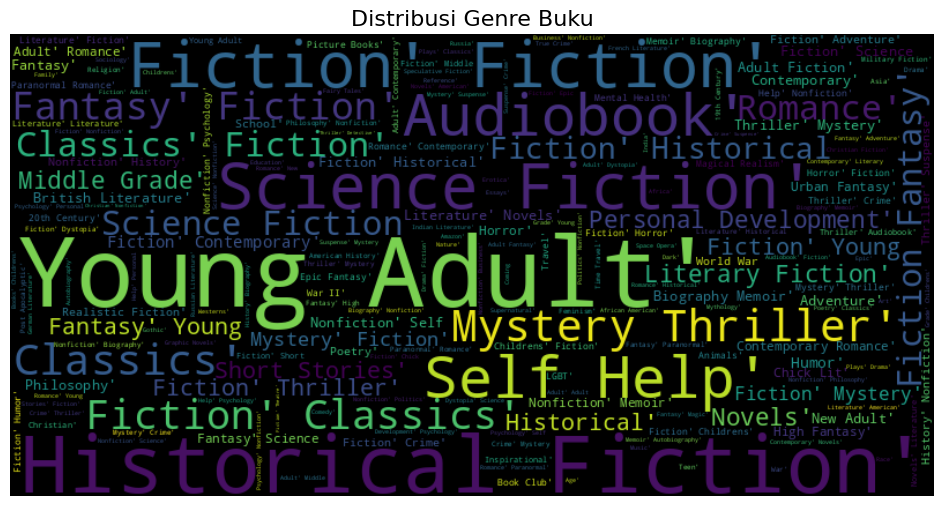

In [ ]:
all_genres = ' '.join(df['Genres'].astype(str))
wordcloud = WordCloud(width=800, height=400).generate(all_genres)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Distribusi Genre Buku', fontsize=16)
plt.axis('off')
plt.show()

### Data Preparation

In [ ]:
# Data Cleaning
df_clean = df.dropna(subset=['Description', 'Genres']).copy()
df_clean['Genres'] = df_clean['Genres'].str.replace(r'[\[\]\']', '', regex=True)  # format Genres

# Gabungkan fitur teks
df_clean['content'] = df_clean['Genres'] + ' ' + df_clean['Description']

### Content-Based Filtering Model

In [ ]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(df_clean['content'])

# Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fungsi get rekomendasi
def get_content_recommendations(title, n=5):
    idx = df_clean[df_clean['Book'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:n+1]]

    return df_clean[['Book', 'Author', 'Genres']].iloc[sim_indices]

### Popularity-Based Recommendation

In [ ]:
# Popularitas score
df['Num_Ratings'] = pd.to_numeric(df['Num_Ratings'], errors='coerce')
df['Avg_Rating'] = pd.to_numeric(df['Avg_Rating'], errors='coerce')

# Menghitung skor popularitas untuk setiap buku
df['popularity_score'] = df['Num_Ratings'] * df['Avg_Rating']

# n=10
def get_popular_books(n=10):
    return df.sort_values('popularity_score', ascending=False)[['Book', 'Author', 'Avg_Rating', 'Num_Ratings']].head(n)

### Evaluasi

In [ ]:
# Evaluasi Content-Based Filtering
def evaluate_content_based(k=5, sample_size=10):
    sample_books = df_clean.sample(sample_size)['Book'].tolist()
    total_precision = 0

    for book in sample_books:
        # Reference genre
        reference_genres = df_clean[df_clean['Book'] == book]['Genres'].values[0].split(', ')

        # Rekomendasi
        recommendations = get_content_recommendations(book, n=k)['Genres'].tolist()

        # Precision: berapa rekomendasi yang memiliki minimal 1 genre sama
        matched = 0
        for rec_genres in recommendations:
            if any(genre in rec_genres.split(', ') for genre in reference_genres):
                matched += 1

        precision = matched / k
        total_precision += precision

    return total_precision / sample_size

# Precision Score
precision_score = evaluate_content_based(k=5, sample_size=20)
print(f"\nEvaluasi Content-Based Filtering:")
print(f"Precision: {precision_score:.2%}")


Evaluasi Content-Based Filtering:
Precision: 54.00%


In [ ]:
# Evaluasi Popularity-Based

df_clean['Num_Ratings'] = pd.to_numeric(df_clean['Num_Ratings'], errors='coerce')
df_clean['Avg_Rating'] = pd.to_numeric(df_clean['Avg_Rating'], errors='coerce')

# popularity_score
df_clean['popularity_score'] = df_clean['Num_Ratings'] * df_clean['Avg_Rating']

# Misal buku dengan Num_Ratings > 900 adalah "bestseller"
df_clean['is_bestseller'] = df_clean['Num_Ratings'] > 900

# Fungsi get popular books
def get_popular_books_clean(n=10):
    return df_clean.sort_values('popularity_score', ascending=False)[['Book', 'Author', 'Avg_Rating', 'Num_Ratings']].head(n)

# Fungsi Evaluate popularity
def evaluate_popularity_based(n=10):
    top_books = get_popular_books_clean(n)

    # Memastikan agar tidak eror saat merge
    top_books['Book'] = top_books['Book'].astype(str)

    df_clean_unique_books = df_clean.drop_duplicates(subset=['Book']).copy()
    df_clean_unique_books['Book'] = df_clean_unique_books['Book'].astype(str)

    bestseller_count = top_books.merge(df_clean_unique_books[df_clean_unique_books['is_bestseller']], on='Book', how='inner').shape[0]

    return bestseller_count / n

# Bestseller di top recommendations
bestseller_ratio = evaluate_popularity_based(n=10)
print(f"Evaluasi Popularity-Based:")
print(f"Bestseller dalam Top 10: {bestseller_ratio:.2%}")

# Tes popular books
# Tes popular books
print("Top 10 Popular Books:")
popular_books_to_display = get_popular_books_clean(10)
html_output_popular_test = popular_books_to_display.to_html(index=False, classes='table table-striped table-bordered')
display(HTML(html_output_popular_test))

Evaluasi Popularity-Based:
Bestseller dalam Top 10: 100.00%
Top 10 Popular Books:


Book,Author,Avg_Rating,Num_Ratings
The Raj Quartet,Paul Scott,4.48,995.0
Living The Best Day Ever,Hendri Coetzee,4.34,997.0
"Hometown Girl After All (Hometown, #2)",Kirsten Fullmer,4.32,999.0
"Hometown Girl After All (Hometown, #2)",Kirsten Fullmer,4.32,999.0
The Chain Between Worlds (The Lost Artefacts #1),Johnathon Nicolaou,4.62,915.0
Ryan White: My Own Story,Ryan White,4.27,971.0
"Christmas in Smithville (Hometown, #4)",Kirsten Fullmer,4.30,964.0
"Proud Pada (The Last Lumenian, #3)",S.G. Blaise,4.33,950.0
The Search for Mother Missing: A Peek Inside International Adoption (Adoption Books for Adults),Janine Vance,4.46,921.0
"Diplomats & Admirals: From Failed Negotiations and Tragic Misjudgments to Powerful Leaders and Heroic Deeds, the Untold Story of the Pacific War from Pearl Harbor to Midway",Dale A. Jenkins,4.28,958.0


### Contoh

In [ ]:
# Contoh 1 rekomendasi konten
print("Content-Based Recommendations 'The Hobbit':")
recommendations = get_content_recommendations('The Hobbit')

if not recommendations.empty:
    html_output = recommendations.to_html(index=False, classes='table table-striped table-bordered')

    # Display
    display(HTML(html_output))
else:
    print("Tidak ada rekomendasi ditemukan untuk 'The Hobbit'.")

Content-Based Recommendations 'The Hobbit':


Book,Author,Genres
"The Hobbit (The Lord of the Rings, #0)",J.R.R. Tolkien,"Fantasy, Classics, Fiction, Adventure, Young Adult, Science Fiction Fantasy, High Fantasy"
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings,J.R.R. Tolkien,"Fantasy, Fiction, Classics, Adventure, Science Fiction Fantasy, Epic Fantasy, High Fantasy"
"The Hobbit, Part One",J.R.R. Tolkien,"Fantasy, Classics, Fiction, Adventure, Science Fiction Fantasy, High Fantasy, Young Adult"
"The Fellowship of the Ring (The Lord of the Rings, #1)",J.R.R. Tolkien,"Fantasy, Classics, Fiction, Adventure, High Fantasy, Science Fiction Fantasy, Epic Fantasy"
Unfinished Tales of Númenor and Middle-Earth,J.R.R. Tolkien,"Fantasy, Fiction, Classics, High Fantasy, Epic Fantasy, Short Stories, Science Fiction Fantasy"


In [ ]:
# Contoh 2 rekomendasi konten
print("Content-Based Recommendations 'The Help':")
recommendations = get_content_recommendations('The Help')

if not recommendations.empty:
    html_output = recommendations.to_html(index=False, classes='table table-striped table-bordered')

    # Display
    display(HTML(html_output))
else:
    print("Tidak ada rekomendasi ditemukan untuk 'The Help'.")

Content-Based Recommendations 'The Help':


Book,Author,Genres
"Kerri's War (The King Trilogy, #3)",Stephen Douglass,"Thriller, Romance, Crime, Amazon"
The Joy Luck Club,Amy Tan,"Fiction, Historical Fiction, Classics, China, Contemporary, Adult Fiction, Adult"
"Lean In: Women, Work, and the Will to Lead",Sheryl Sandberg,"Nonfiction, Business, Feminism, Self Help, Leadership, Audiobook, Womens"
"World Without End (Kingsbridge, #2)",Ken Follett,"Historical Fiction, Fiction, Historical, Medieval, Audiobook, British Literature, Fantasy"
"Penis Politics: A Memoir of Women, Men and Power",Karen Hinton,Nonfiction


In [ ]:
# Contoh rekomendasi popularitas
print("Top 10 Popular Books:")
popular_recommendations = get_popular_books()

if not popular_recommendations.empty:
    html_output_popular = popular_recommendations.to_html(index=False, classes='table table-striped table-bordered')

    # Display
    display(HTML(html_output_popular))
else:
    print("Tidak ada buku populer ditemukan.")

Top 10 Popular Books:


Book,Author,Avg_Rating,Num_Ratings
The Raj Quartet,Paul Scott,4.48,995.0
Living The Best Day Ever,Hendri Coetzee,4.34,997.0
"Hometown Girl After All (Hometown, #2)",Kirsten Fullmer,4.32,999.0
"Hometown Girl After All (Hometown, #2)",Kirsten Fullmer,4.32,999.0
Glucose Control Eating: Lose Weight Stay Slimmer Live Healthier Live Longer,Rick Mystrom,4.31,984.0
The Chain Between Worlds (The Lost Artefacts #1),Johnathon Nicolaou,4.62,915.0
Ryan White: My Own Story,Ryan White,4.27,971.0
"Christmas in Smithville (Hometown, #4)",Kirsten Fullmer,4.30,964.0
"Proud Pada (The Last Lumenian, #3)",S.G. Blaise,4.33,950.0
The Search for Mother Missing: A Peek Inside International Adoption (Adoption Books for Adults),Janine Vance,4.46,921.0


### Simpan

In [ ]:
# Simpan data
# Contoh 1 rekomendasi konten
content_rec_hobbit = get_content_recommendations('The Hobbit')

# Contoh 2 rekomendasi konten
content_rec_help = get_content_recommendations('The Help')

# Contoh rekomendasi popularitas
popular_rec = get_popular_books()

# Simpan rekomendasi ke CSV
content_rec_hobbit.to_csv('book_recommendations_hobbit.csv', index=False)
content_rec_help.to_csv('book_recommendations_help.csv', index=False)
popular_rec.to_csv('popular_book_recommendations.csv', index=False)